# Armazenamento no drive

In [ ]:
# Preparando o ambiente no Google Drive:

# Importando a biblioteca
from google.colab import drive

# Isso irá pedir sua autorização
drive.mount('/content/drive')

# Agora, seu Drive estará disponível em: /content/drive/My Drive

Mounted at /content/drive


# Importação das bibliotecas

In [ ]:
# Biblioteca para mapa
import folium
from folium import plugins

# Biblioteca para conexao com o banco de dados
import psycopg2
# psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
# psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

# Biblioteca para os dados em geojson
import json

# Bibliotecas dos widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import AppLayout
from ipywidgets import Layout, VBox, Label

# import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

# Biblioteca de mediacao dos parametros de conexao do banco de dados
from configparser import ConfigParser

# Biblioteca para fazer a classificao de quebras naturais nos dados
# Instalando biblioteca para fazer quebras naturais
!pip install jenkspy

# Biblioteca para plotar gráfico das classes encontradas pelo jenkspy
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=70364 sha256=abe1a4008063064b1d4aaab14304d48d26add88344e5eba6a1f2d79f7a295fd0
  Stored in directory: /root/.cache/pip/wheels/e5/ab/c7/449bc908636d689818fca058a9b530f61220b634a09597a69d
Successfully built jenkspy


# Conexão com o banco de dados

In [ ]:
def config(filename='/content/drive/My Drive/Colab Notebooks/database_mapfor.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [ ]:
conn = None
try:
  # read connection parameters
  params = config()
  # connect to the PostgreSQL server
  print('Connecting to the PostgreSQL database...')
  conn = psycopg2.connect(**params)
  # create a cursor
  cursor = conn.cursor()
  print ('Conexao realizada com sucesso')
except (Exception, psycopg2.DatabaseError) as error:
  print(error)
  print ('Erro na conexao com o banco de dados')

Connecting to the PostgreSQL database...
Conexao realizada com sucesso


# Consulta da quantidade de vagas por cursos de formação em educação


In [ ]:
# Combox com as formacoes especificas
# Funcao para fazer a lista do comboBox 
def lista_ocde_area():
  ocde_area = []
  cursor.execute("""SELECT cod_ocde_area, nm_ocde_area FROM cursos_emec WHERE nm_ocde_area_geral = 'Educaçao' GROUP BY  cod_ocde_area, nm_ocde_area ORDER BY nm_ocde_area ASC;""")
  fet_list = cursor.fetchall()
  conn.commit()
  for nm_ocde_area, cod_ocde_area in fet_list:
    ocde_area.append((cod_ocde_area, nm_ocde_area))
  return ocde_area

# Definindo dropbox
print("Curso de formação na área de Educação")
drop_ocde = widgets.Dropdown(
    options = lista_ocde_area())

# Mostrando a caixa de escolha
display(drop_ocde)

Curso de formação na área de Educação


Dropdown(options=(('Administraçao educacional', '142A01'), ('Formaçao de professor das séries iniciais do ensi…

## Classificação dos dados em Quebras Naturais (Jenks)

In [ ]:
import jenkspy
nome_area = drop_ocde.value

# Funcao para consultar a quantidade de vagas do curso escolhido no widget
def lista_vagas():
  qta_vagas_list = []
  cursor.execute("""SELECT sum(qta_vagas) as qta_vagas FROM cursos_emec, iesup WHERE cursos_emec.cod_ies = iesup.cod_ies AND cod_ocde_area_geral = 1 AND cod_ocde_area = '%s' GROUP BY iesup.cod_ies, cursos_emec.cod_ocde_area; """ %(nome_area))
  fet_list = cursor.fetchall()
  conn.commit()
  for qta_vagas in fet_list:
    qta_vagas_list.append(qta_vagas)
  lis_vagas = [item for t in qta_vagas_list for item in t] 
  return lis_vagas

print(lista_vagas(),len(lista_vagas()))


[40, 340, 127, 17000, 500, 134, 308, 80, 690, 100, 1040, 80, 1500, 6000, 5120, 200, 3600, 200, 50, 50, 100, 80, 200, 50, 150, 40, 50, 100, 40, 50, 200] 31


In [ ]:
# Conjunto de dados de entrada
data = lista_vagas()

if len(data) == 1:
  breaks = data
elif len(data) == 2:
  breaks = data
elif len(data) <= 5:
  nb_class = len(data)-1
  breaks = jenkspy.jenks_breaks(data, nb_class)
else:
  nb_class = 5
  breaks = jenkspy.jenks_breaks(data, nb_class)

breaks

[40.0, 500.0, 1500.0, 3600.0, 6000.0, 17000.0]

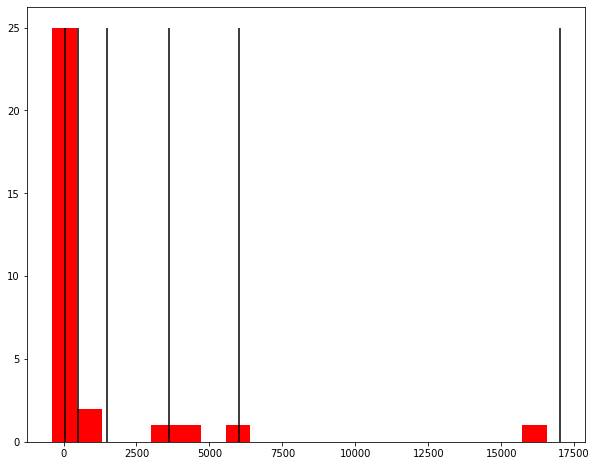

In [ ]:
# Plota as classes determinadas por quebras naturais
plt.style.use('seaborn-pastel')

%matplotlib inline
plt.figure(figsize = (10,8))
hist = plt.hist(data, bins=20, align='left', color='r')
for b in breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

# Consulta da porcentagem de professores formados com pós-graduação agrupados por escolas nos município


In [ ]:
# Widget para escolher qual agrupamento dos dados com relação a formação dos proessores em pós-graduação
agrup_form = widgets.RadioButtons(
    options=['Todas', 'Municipais', 'Estaduais'],
    value='Todas',
    description='Escolas:',
    disabled=False
)
display(agrup_form)

RadioButtons(description='Escolas:', options=('Todas', 'Municipais', 'Estaduais'), value='Todas')

In [ ]:
nivel_form = agrup_form.value

if nivel_form == 'Todas':
  # consulta para classificar os municipios com relacao ao total de escolas
  nivel_form_geo = folium.WmsTileLayer(
      url = 'https://200.17.225.171/geoserver/mapfor/wms', 
      layers = 'mapfor:mun_total_prof',  
      fmt='image/png',
      transparent=True,
      version='1.1.1',
      name = 'Porcentagem de professores com pos graduacao - Total',
      attr = 'INEP',
      overlay=True,
      control=True,
      show=True)
elif nivel_form == 'Municipais':
  # consulta para classificar os municipios com relacao as escolas municipais
  nivel_form_geo = folium.WmsTileLayer(
      url = 'https://200.17.225.171/geoserver/mapfor/wms', 
      layers = 'mapfor:mun_mun_prof',  
      fmt='image/png',
      transparent=True,
      version='1.1.1',
      name = 'Porcentagem de professores com pos graduacao - Escolas Municipais',
      attr = 'INEP',
      overlay=True,
      control=True,
      show=True)
else:
  # consulta para classificar os municipios com relacao as escolas estaduais
  nivel_form_geo = folium.WmsTileLayer(
      url = 'https://200.17.225.171/geoserver/mapfor/wms', 
      layers = 'mapfor:mun_est_prof',  
      fmt='image/png',
      transparent=True,
      version='1.1.1',
      name = 'Porcentagem de professores com pos graduacao - Escolas Estaduais',
      attr = 'INEP',
      overlay=True,
      control=True,
      show=True)

## Mapa

In [ ]:
# Consultando os dados espaciais do curso escolhido no widget
cursor.execute("""CREATE OR REPLACE VIEW vagas_cursos_ocde AS SELECT iesup.cod_ies, sum(qta_vagas) as qta_vagas, iesup.geom, cod_ocde_area FROM cursos_emec, iesup 
WHERE cursos_emec.cod_ies = iesup.cod_ies AND nm_ocde_area_geral = 'Educaçao' AND cod_ocde_area = '%s'
GROUP BY iesup.cod_ies, iesup.geom, cursos_emec.cod_ocde_area; """ %(nome_area))
conn.commit()
# cursor.close()
# conn.close()

In [ ]:
classes = breaks

# Funcao que testa quantas classes tem os dados que o usuario escolheu e determina a url que será passada para o geoserver, para que o dado seja classificado conforme as classes calculadas para cada dado.
def num_class_url():
  if len(classes) == 0:
    url = 'https://200.17.225.171/geoserver/mapfor/wms'
  elif len(classes) == 1:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s'%(classes[0])
  elif len(classes) == 2:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s' %(classes[0], classes[1])
  elif len(classes) == 3:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s;inicial2:%s;final2:%s' %(classes[0], classes[1], classes[1], classes[2])
  elif len(classes) == 4:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s;inicial2:%s;final2:%s;inicial3:%s;final3:%s' %(classes[0], classes[1], classes[1], classes[2], classes[2], classes[3])
  elif len(classes) == 5:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s;inicial2:%s;final2:%s;inicial3:%s;final3:%s;inicial4:%s;final4:%s' %(classes[0], classes[1], classes[1], classes[2], classes[2], classes[3], classes[3], classes[4])
  elif len(classes) > 5:
    url = 'https://200.17.225.171/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s;inicial2:%s;final2:%s;inicial3:%s;final3:%s;inicial4:%s;final4:%s;inicial5:%s;final5:%s' %(classes[0], classes[1], classes[1], classes[2], classes[2], classes[3], classes[3], classes[4],  classes[4],  classes[5])
  else:
    url = 'https://200.17.225.171/geoserver/mapfor/wms'
  return url

In [ ]:
nome_area = drop_ocde.value

m = folium.Map(location = [-24.647,-51.578],
               height = '90%',
               zoom_start = 8,
               tiles = 'OpenStreetMap',
               attr = '© contribuidores do OpenStreetMap (CC BY-SA 2.0)')

# Número de professores formados po municipios do parana conforme agrupamento escolhido pelo widget
nivel_form_geo.add_to(m)

# Regionais de Educação
folium.WmsTileLayer(
    url = 'https://200.17.225.171/geoserver/mapfor/wms', 
    layers = 'mapfor:NRE_pr',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'Nucleos Regionais de Educação',
    attr='SEED',
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# IES classificadas com relacao ao número de vagas por curso de formação
folium.WmsTileLayer(
  url = num_class_url(), 
  layers = 'mapfor:vagas_cursos_ocde',  
  fmt='image/png', 
  transparent=True, 
  version='1.1.1', 
  name = 'Vagas em %s'%drop_ocde.label,
  attr = 'INEP',
  overlay=True, 
  control=True, 
  show=True).add_to(m)

folium.LayerControl().add_to(m)
m